<center><b><h2><font color = 'green'> POS tagging using Vanilla Viterbi and Modified Viterbi </h2></b></center>

<b><u><h3><font color = 'green'> Objectives </h3></u></b>


- Vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words)

- Solve the problem of unknown words using at least two techniques. 

- Compare the tagging accuracy after making these modifications with the Vanilla Viterbi algorithm.

- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were 
incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

<b><u><h3><font color = 'green'> Data Preparation</h3></u></b>

In [1]:
#Importing libraries
import nltk, re
import requests
import random
import numpy as np
import pandas as pd
import pprint, time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\SRINU\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SRINU\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
file_path = "D:\\DataScientist\\"
file_name = "Test_sentences.txt"

In [4]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [5]:
# let's print few of the tagged data
print(nltk_data[:5])


[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [6]:
# split data into training and validation set in the ratio 95:5
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, train_size=0.95, test_size=0.05)

print("Training Set Length :", len(train_set))
print("Test Set Length :", len(test_set))
print("-" * 125)
print("Training Data:\n")
print(train_set[:5])

Training Set Length : 3718
Test Set Length : 196
-----------------------------------------------------------------------------------------------------------------------------
Training Data:

[[('The', 'DET'), ('report', 'NOUN'), ('from', 'ADP'), ('the', 'DET'), ('Fed', 'NOUN'), ('found', 'VERB'), ('that', 'ADP'), ('manufacturing', 'NOUN'), (',', '.'), ('in', 'ADP'), ('particular', 'ADJ'), (',', '.'), ('has', 'VERB'), ('been', 'VERB'), ('weak', 'ADJ'), ('in', 'ADP'), ('recent', 'ADJ'), ('weeks', 'NOUN'), ('.', '.')], [('Thousands', 'NOUN'), ('of', 'ADP'), ('East', 'NOUN'), ('Germans', 'NOUN'), ('fled', 'VERB'), ('to', 'PRT'), ('Czechoslovakia', 'NOUN'), ('after', 'ADP'), ('the', 'DET'), ('East', 'NOUN'), ('Berlin', 'NOUN'), ('government', 'NOUN'), ('lifted', 'VERB'), ('travel', 'NOUN'), ('restrictions', 'NOUN'), ('.', '.')], [('If', 'ADP'), ('a', 'DET'), ('competitor', 'NOUN'), ('enters', 'VERB'), ('the', 'DET'), ('game', 'NOUN'), (',', '.'), ('for', 'ADP'), ('example', 'NOUN'), (',', '

In [7]:
# list of training set tagged words

training_tagged_words = [tup for sent in train_set for tup in sent]

print('Total Tagged words in Training set :', len(training_tagged_words))
print('-' * 125)
print('Top 10 Tagged words in Training set :\n\n', training_tagged_words[:10])

Total Tagged words in Training set : 95718
-----------------------------------------------------------------------------------------------------------------------------
Top 10 Tagged words in Training set :

 [('The', 'DET'), ('report', 'NOUN'), ('from', 'ADP'), ('the', 'DET'), ('Fed', 'NOUN'), ('found', 'VERB'), ('that', 'ADP'), ('manufacturing', 'NOUN'), (',', '.'), ('in', 'ADP')]


In [8]:
#training_tagged_words

<b><u><h3><font color = 'green'> Custom Functions </h3></u></b>

In [9]:
# function to extract nested tuple value

def get_nested_tuple_from_list(input_list, index):
    if index == -1:
        return [tup for sent in input_list for tup in sent]
    else:
        return [tup[index] for sent in input_list for tup in sent]

In [10]:
# function to extract value from tuple by index position

def get_tuple_value_from_list(input_list, index):
    if index == -1:
        return [pair for pair in input_list]
    else:
        return [pair[index] for pair in input_list]
    

In [11]:
# function to convert list to set object

def convert_list_to_set(input_list):
    return set(input_list)

In [12]:
# function to get values from set

def get_value_from_set(input_set):
    return [res for res in input_set]

In [13]:
# function to convert tuple value to list

def get_list_from_tuple_values(input_tuple, index):
    return list(set(get_tuple_value_from_list(input_tuple, index)))

In [14]:
# funtion to compute Emission Probability(word given tag): 

def emission_probability_word_given_tag(word, tag, training_bag = training_tagged_words):
    tag_list = [pair for pair in training_bag if pair[1] == tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [15]:
# Vanilla Viterbi Algorithm
def vanilla_viterbi(words, training_bag = training_tagged_words):
    state = []
    #T = list(set([pair[1] for pair in train_bag]))
    T = list(set(get_tuple_value_from_list(training_bag, 1)))
        
    for key, word in enumerate(words):
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = df_tags.loc['.', tag]
            else:
                transition_p = df_tags.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = emission_probability_word_given_tag(words[key], tag)[0]/emission_probability_word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting maximum probability state
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [16]:
# compute Transition Probability (tag given tag: tag2(t2) given tag1 (t1))

def transition_probability_t2_given_t1(t2, t1, training_bag = training_tagged_words):
    tags = [pair[1] for pair in training_bag]
    count_t1 = len([t for t in tags if t == t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index] == t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [17]:
# Modified Viterbi Heuristic for Unknown words
def unknown_words_with_vanilla_viterbi(words, training_bag = training_tagged_words):
    state = []
    #T = list(set([pair[1] for pair in train_bag]))
    T = list(set(get_tuple_value_from_list(training_bag, 1)))
    
    for key, word in enumerate(words):
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = df_tags.loc['.', tag]
            else:
                transition_p = df_tags.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = emission_probability_word_given_tag(words[key], tag)[0]/emission_probability_word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in training_vocabulary_set:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [18]:
# extracting top 10 tokens from the training_tagged_words

training_data_tokens = get_tuple_value_from_list(training_tagged_words, 0)

print('Top 10 tagged words:', training_data_tokens[:10])

Top 10 tagged words: ['The', 'report', 'from', 'the', 'Fed', 'found', 'that', 'manufacturing', ',', 'in']


In [19]:
# extracting top 10 POS tags for the training_tagged_words

training_data_pos_tags = get_tuple_value_from_list(training_tagged_words, 1)

print('Top 10 POS Tags :', training_data_pos_tags[:10])

Top 10 POS Tags : ['DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'VERB', 'ADP', 'NOUN', '.', 'ADP']


In [20]:
# building the train vocabulary set from training data tokens

training_vocabulary_set = convert_list_to_set(training_data_tokens)

print('Top 10 Vocabulary: ', get_value_from_set(training_vocabulary_set)[:10])

Top 10 Vocabulary:  ['circuit-board', 'APPEARS', 'high-stakes', 'Photography', 'fraud', 'fancy', 'psychology', 'mollified', 'Generalized', 'Rick']


In [21]:
# converting train POS tags to a set

training_pos_tag_set = convert_list_to_set(training_data_pos_tags)

print('Top 10 POS Tags: ', get_value_from_set(training_pos_tag_set)[:10])

Top 10 POS Tags:  ['ADV', 'VERB', 'NOUN', 'DET', 'PRON', 'CONJ', 'ADP', 'X', '.', 'PRT']


In [22]:
print("Length of Vocabulary:", len(training_vocabulary_set))
print("Length of POS Tags:", len(training_pos_tag_set)) 
print("Available POS Tags:", training_pos_tag_set) 

Length of Vocabulary: 12054
Length of POS Tags: 12
Available POS Tags: {'ADV', 'VERB', 'NOUN', 'DET', 'PRON', 'CONJ', 'ADP', 'X', '.', 'PRT', 'NUM', 'ADJ'}


<b><u><h3><font color = 'green'> POS Tagging Algorithm - HMM </h3></u></b>

Hidden Markov Model based algorithm is used to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word.

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). 

Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

P(w/t) = count(w, t) / count(t).

The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun.

Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will be zero

<b><u><h3><font color = 'green'> Emission Probabilities (i.e. probability of a word given a tag) </h3></u></b>

In [23]:
# computing P(w/t) and storing in [Tags x Vocabulary] matrix. This is a matrix with dimension
# of len(training_pos_tag_set) X len(training_vocabulary_set)

len_pos_tags = len(training_pos_tag_set)
len_vocabulary = len(training_vocabulary_set)

word_given_tag = np.zeros((len_pos_tags, len_vocabulary))

<b><u><h3><font color = 'green'>Transition Probabilities (i.e. probability of getting a tag t2 given that the tag for previous word was t1) </h3></u></b>

In [24]:
# creating t x t transition matrix of tags

tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = transition_probability_t2_given_t1(t2, t1)[0]/transition_probability_t2_given_t1(t2, t1)[1]

# print transition matrix
tags_matrix

array([[7.96932280e-02, 3.42780918e-01, 3.16772275e-02, 6.90230057e-02,
        1.53384460e-02, 7.00233411e-03, 1.19706571e-01, 2.26742253e-02,
        1.36045352e-01, 1.50050018e-02, 3.20106708e-02, 1.29043013e-01],
       [8.17057043e-02, 1.68547198e-01, 1.10263795e-01, 1.34386435e-01,
        3.58726941e-02, 5.13578719e-03, 9.20550898e-02, 2.18115315e-01,
        3.50945443e-02, 3.13594267e-02, 2.25663371e-02, 6.48976713e-02],
       [1.66630279e-02, 1.46401808e-01, 2.64170855e-01, 1.30248126e-02,
        4.69329860e-03, 4.27126549e-02, 1.76853672e-01, 2.90693436e-02,
        2.40813509e-01, 4.39132638e-02, 9.53212567e-03, 1.21516408e-02],
       [1.25452355e-02, 3.94451134e-02, 6.37997568e-01, 5.66948112e-03,
        3.37756332e-03, 4.82509058e-04, 9.40892659e-03, 4.58383597e-02,
        1.79734621e-02, 2.41254529e-04, 2.20747888e-02, 2.04945713e-01],
       [3.39113697e-02, 4.81695563e-01, 2.13102117e-01, 9.63391177e-03,
        7.70712923e-03, 5.39499056e-03, 2.23506745e-02, 9.32

In [25]:
# converting the matrix to a data frame
df_tags = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))

# print data
df_tags

,ADV,VERB,NOUN,DET,PRON,CONJ,ADP,X,.,PRT,NUM,ADJ
ADV,0.079693,0.342781,0.031677,0.069023,0.015338,0.007002,0.119707,0.022674,0.136045,0.015005,0.032011,0.129043
VERB,0.081706,0.168547,0.110264,0.134386,0.035873,0.005136,0.092055,0.218115,0.035095,0.031359,0.022566,0.064898
NOUN,0.016663,0.146402,0.264171,0.013025,0.004693,0.042713,0.176854,0.029069,0.240814,0.043913,0.009532,0.012152
DET,0.012545,0.039445,0.637998,0.005669,0.003378,0.000483,0.009409,0.045838,0.017973,0.000241,0.022075,0.204946
PRON,0.033911,0.481696,0.213102,0.009634,0.007707,0.005395,0.022351,0.093256,0.040077,0.012331,0.007707,0.072832
CONJ,0.053878,0.153275,0.352531,0.119833,0.057594,0.000464,0.052485,0.008360,0.035764,0.005109,0.040873,0.119833
ADP,0.013954,0.008628,0.323818,0.323392,0.069876,0.000852,0.016723,0.034512,0.039305,0.001385,0.061035,0.106519
X,0.025800,0.203854,0.061156,0.055264,0.055582,0.010352,0.146361,0.074534,0.163243,0.183469,0.002867,0.017519
.,0.052386,0.089729,0.222531,0.173547,0.064476,0.057849,0.090535,0.026596,0.093400,0.002328,0.081848,0.044685
PRT,0.009480,0.401438,0.248120,0.101013,0.017326,0.002288,0.019614,0.013403,0.042824,0.001961,0.057208,0.085322


<b><u><h3><font color = 'green'> Exploratory Data Analysis </h3></u></b>

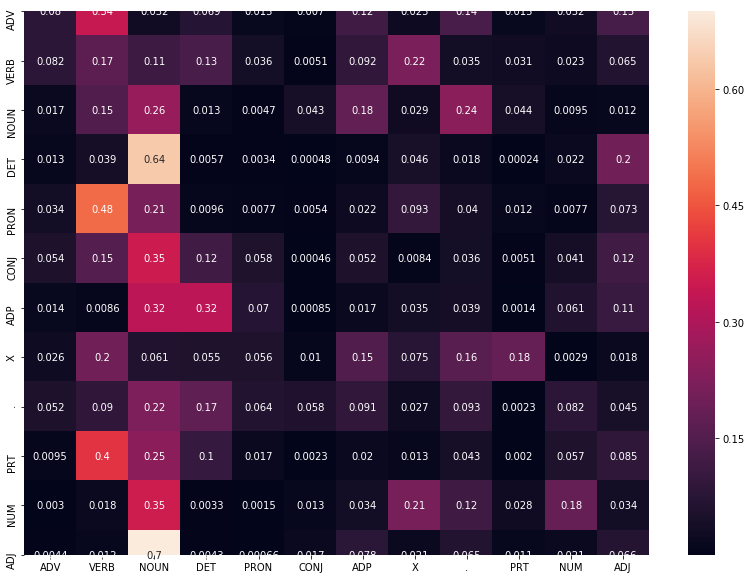

In [26]:
# heatmap of tags matrix
plt.figure(figsize=(14, 10))
sns.heatmap(df_tags, annot = True)
plt.show()

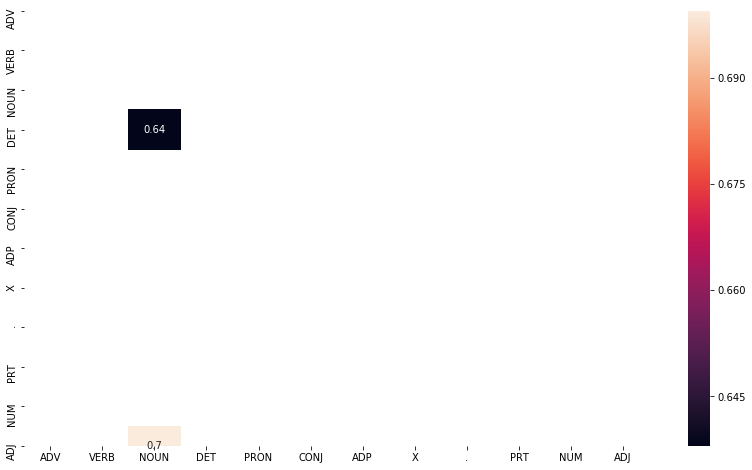

In [27]:
# frequent tags

frequent_tags = df_tags[df_tags>0.5]
plt.figure(figsize=(14, 8))
sns.heatmap(frequent_tags, annot = True)
plt.show()

<b><u><h3><font color = 'green'> Build the Vanilla Viterbi based POS tagger</h3></u></b>

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

Note: P(tag|start) = P(tag|'.')

<b><u><h3><font color = 'green'> Testing Vanilla Viterbi Algorithm on sampled test data </h3></u></b>

In [28]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
# since running it on the entire data set will take many hours

random.seed(1234)

# tagged words
tagged_words = get_nested_tuple_from_list(test_set, -1)

# untagged words
test_tagged_words = get_nested_tuple_from_list(test_set, 0)

In [29]:
# tagging the test sentences
start = time.time()
test_tagged_seq = vanilla_viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [30]:
print("Time taken in seconds: ", difference)
print(test_tagged_seq)

Time taken in seconds:  1359.7656173706055
[('Stockbrokers', 'ADV'), ("'", 'PRT'), ('business', 'NOUN'), ('and', 'CONJ'), ('pay', 'VERB'), ('has', 'VERB'), ('been', 'VERB'), ('falling', 'VERB'), ('.', '.'), ('After', 'ADP'), ('troubled', 'ADJ'), ('Heritage', 'NOUN'), ('Media', 'NOUN'), ('proposed', 'VERB'), ('*-1', 'X'), ('acquiring', 'VERB'), ('POP', 'NOUN'), ('Radio', 'NOUN'), ('in', 'ADP'), ('a', 'DET'), ('stock', 'NOUN'), ('swap', 'NOUN'), (',', '.'), ('POP', 'NOUN'), ('Radio', 'NOUN'), ("'s", 'PRT'), ('shares', 'NOUN'), ('tumbled', 'VERB'), ('4', 'NUM'), ('to', 'PRT'), ('14', 'NUM'), ('3\\/4', 'NUM'), ('.', '.'), ('Mrs.', 'NOUN'), ('Ward', 'NOUN'), (',', '.'), ('for', 'ADP'), ('one', 'NUM'), (',', '.'), ('was', 'VERB'), ('relieved', 'ADV'), ('.', '.'), ('``', '.'), ('*', 'X'), ('Compare', 'ADV'), ('two', 'NUM'), ('candidates', 'NOUN'), ('for', 'ADP'), ('mayor', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('the', 'DET'), ('announcer', 'NOUN'), ('.', '.'), ('

In [31]:
# accuracy of the vanilla viterbi algorithm

check = [i for i, j in zip(test_tagged_seq, tagged_words) if i == j]

vanilla_viterbi_accuracy = len(check)/len(test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm is :", vanilla_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm is : 0.900564743848326


In [32]:
# understand the incorrect tagged cases

incorrect_tagged_cases = [[tagged_words[i-1],j] for i, j in enumerate(zip(test_tagged_seq, tagged_words)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
#incorrect_tagged_cases

493


<b><u><h3><font color = 'green'> Unknow words </h3></u></b>

In [33]:
# Unknown words 

test_vocab_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocab_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :\n\n", unknown_words)

Total Unknown words : 354


Unknown Words :

 ['F.H.', 'enjoy', 'sit', 'boarding', '23,403', 'tallies', 'Kawasaki', '16.05', 'Composer', 'verge', 'bass', 'sterling', 'gubernatorial', '11.5', 'cultivated', 'spook', 'intraocular', 'arrested', 'lawmaking', 'Mortimer', 'Brenda', 'lay', 'early-retirement', 'curly', 'predictable', '2,700', 'remorse', 'NBC-owned', 'Angelo', '1998', 'execs', 'computerize', 'retorts', '1.916', 'Unfortunately', 'decries', 'indexes', 'estimation', '95.09', 'export-oriented', 'lasting', 'Seattle', 'Topix', 'Barclays', 'less-than-brilliant', '138', 'Marty', 'Bellows', 'diethylstilbestrol', 'centralized', 'muster', 'POTABLES', '*-158', 'excited', '420', 'U.S.-Japanese', 'discounts', 'ethanol', 'brightened', 'underscore', 'arrival', 'fixtures', 'devoted', 'sorts', 'collective-bargaining', 'Marder', 'Heavy', 'sticker-shock', 'reps', '88.32', 'acquirers', "'50s", 'Desai', 'counteract', 'Convention', 'astronomical', 'docile', 'Osborn', 'Beginning', 'WTVJ', '4,393,237', 

<b><u><h3><font color = 'green'>  Solve the problem of Unknown Words </h3></u></b>

<b><u><h3><font color = 'green'>Method 1 </h3></u></b>

###### Vanilla Viterbi algorithm achieved an accuracy of about 90%. This approx. 10% loss of accuracy.

###### Loss was majorly due to unknown word (i.e. not present in the training set), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

###### If unknown word in the training vocabulary then its emission probability will be ZERO and state probability will inturn be ZERO.

##### If unknown word encounters, we can omit Emission probability and  consider Transition probability

In [34]:
# tagging the test sentences
start = time.time()
unknown_word_test_tagged_seq = unknown_words_with_vanilla_viterbi(test_tagged_words)

# accuracy
test_unknown_word_check = [i for i, j in zip(unknown_word_test_tagged_seq, tagged_words) if i == j]

optimized_viterbi_accuracy = len(test_unknown_word_check)/len(unknown_word_test_tagged_seq)

end = time.time()
difference = end-start

In [35]:
print("Time taken in seconds: ", difference)
print("Accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is:", optimized_viterbi_accuracy)

Time taken in seconds:  1322.4564156532288
Accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is: 0.9352561516740622


##### Accuracies: 

In [36]:
vanilla_accuracy = round(vanilla_viterbi_accuracy, 4)*100
optimized_vanilla_accuracy = round(optimized_viterbi_accuracy, 4)*100 
accuracy_loss = round(100 - optimized_vanilla_accuracy, 2)

print(f'Vanilla Viterbi Algorithm  : {vanilla_accuracy}%')

print(f'Vanilla Viterbi Algorithm with handling unknown words: {optimized_vanilla_accuracy}%')

print(f'Still approx. {accuracy_loss}% loss present , so try with some Lexicon and Rule-Based Models for POS Tagging')

Vanilla Viterbi Algorithm  : 90.06%
Vanilla Viterbi Algorithm with handling unknown words: 93.53%
Still approx. 6.47% loss present , so try with some Lexicon and Rule-Based Models for POS Tagging


In [37]:
# Unigram Tagger

unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)
print("Unigram Tagger Accuracy: ", unigram_tagger_accuracy)

Unigram Tagger Accuracy:  0.8981444130697862


Combining the Unigram Tagger with a rule based regex tagger.

In [38]:
# rule based regex tagger

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [39]:
# rule based RegexpTagger

rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

In [40]:
print("Unigram Tagger Accuracy backed up by the RegexpTagger:", accuracy_rule_based_unigram_tagger)

Unigram Tagger Accuracy backed up by the RegexpTagger: 0.9328358208955224


In [41]:
# Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)

In [42]:
print("Bigram Tagger Accuracy backed up by the rule based unigram tagger:", accuracy_bigram_tagger)

Bigram Tagger Accuracy backed up by the rule based unigram tagger: 0.936062928600242


In [43]:
# trigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)

In [44]:
print("Trigram Tagger accuracy backed up by the bigram tagger:", accuracy_trigram_tagger)

Trigram Tagger accuracy backed up by the bigram tagger: 0.9334409035901573


<b><u><h3><font color = 'green'> Method 2 </h3></u></b>
###### Trigram Tagger backed up by the bigram tagger accuracy is: 93.55%. 

###### Modify the viterbi algorithm to use trigram tagger as a back-off. 

###### When the Viterbi algorithm is not able to tag an unknown word, it uses the rule-based tagger.

In [45]:
# function trigram_tagger
def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [46]:
#function Viterbi_Backedup_By_Trigram_Tagger
def Viterbi_Backedup_By_Trigram_Tagger(words, training_bag = training_tagged_words):
    state = []
    tag_set = list(set(get_tuple_value_from_list(training_bag, 1))) #list(set([pair[1] for pair in training_bag]))
    
    # unknown words with trigram tagger backed up by the rule based tagger

    for key, word in enumerate(words):
        if word not in training_vocabulary_set:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = df_tags.loc['.', tag]
                else:
                    transition_p = df_tags.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = emission_probability_word_given_tag(words[key], tag)[0]/emission_probability_word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

<b><u><h3><font color = 'green'>Evaluating tagging accuracy </h3></u></b>

In [47]:
# tagging the test sentences
start = time.time()
viterbi_trigram_tagged_seq = Viterbi_Backedup_By_Trigram_Tagger(test_tagged_words)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, tagged_words) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)
end = time.time()
difference = end-start

In [48]:
print("Time taken in seconds: ", difference)
print("viterbi backed up by trigram tagger accuracy:", viterbi_trigram_accuracy)

Time taken in seconds:  3603.910690307617
viterbi backed up by trigram tagger accuracy: 0.9538120209762001


<b><u><h3><font color = 'green'> Compare tagging accuracies of the modifications with the Vanilla Viterbi algorithm</h3></u></b>
    
<b><u><h5><font color = 'green'> 1. Check tagging accuracy on the test_set data generated using the test_train_split</h5></u></b>

In [49]:
data_acccuracy = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], 
                  ['Optimized Vanilla Viterbi', optimized_viterbi_accuracy*100], 
                  ['Unigram Tagger', unigram_tagger_accuracy*100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger*100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

df_data_acccuracy = pd.DataFrame(data_acccuracy, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

df_data_acccuracy.set_index('Tagging_Algorithm', drop = True, inplace = True)

df_data_acccuracy

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,90.056474
Optimized Vanilla Viterbi,93.525615
Unigram Tagger,89.814441
Unigram + RegexpTagger,93.283582
Bigram Tagger + Unigram_tagger,93.606293
Trigram Tagger + Bigram_tagger,93.344090
Viterbi + Trigram_tagger,95.381202


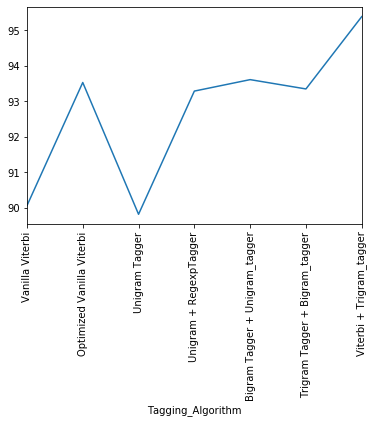

In [50]:
df_data_acccuracy.plot.line(rot = 90, legend = False)

<b><u><h5><font color = 'green'>2. Check tagging accuracies for the algorithm on the sample test sentences </h5></u></b>

In [51]:
test_sentences = []
test_file = open(file_path + file_name, 'r')

for line in test_file:
    test_sentences.append(line)
test_file.close()

In [52]:
test_tokenized_sents = [word_tokenize(sent) for sent in test_sentences]
test_corpus_pos_tags = nltk.pos_tag_sents(test_tokenized_sents, tagset = 'universal')
test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [53]:
# untagged words from the test data provided
test_tagged_words = get_nested_tuple_from_list(test_corpus_pos_tags, 0)

# tagged words
tagged_words_test_run_base  = get_nested_tuple_from_list(test_corpus_pos_tags, -1)

In [54]:
test_tagged_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

<b><u><h5><font color = 'green'>1. Testing the accuracy of Vanilla Viterbi on sample test data</h5></u></b>

In [55]:
# tagging the test sentences
sample_data_test_tagged_seq = vanilla_viterbi(test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_data_test_check = [i for i, j in zip(sample_data_test_tagged_seq, tagged_words_test_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_data_test_check)/len(sample_data_test_tagged_seq)

In [56]:
print("Vanilla Viterbi Algorithm accuracy on the sample test data:", vanilla_viterbi_accuracy_on_sample_test_data)

Vanilla Viterbi Algorithm accuracy on the sample test data: 0.7569060773480663


<b><u><h5><font color = 'green'> 2. Testing the accuracy of Vanilla_Viterbi_With_Unknown_Words on sample test data </h5></u></b>

In [57]:
# tagging the test sentences
sample_test_data_unknown_word_tagged_seq = unknown_words_with_vanilla_viterbi(test_tagged_words)

# accuracy
sample_test_data_unknown_word_check = [i for i, j in zip(sample_test_data_unknown_word_tagged_seq, tagged_words_test_run_base) if i == j]

sample_test_data_optimized_viterbi_accuracy = len(sample_test_data_unknown_word_check)/len(sample_test_data_unknown_word_tagged_seq)

In [58]:

print("unknown_words_with_vanilla_viterbi accuracy on the sample test data:", sample_test_data_optimized_viterbi_accuracy)

unknown_words_with_vanilla_viterbi accuracy on the sample test data: 0.8895027624309392


<b><u><h5><font color = 'green'> 3. Testing the accuracy of Viterbi_Backedup_By_Trigram_Tagger on sample test data</h5></u></b>

In [59]:
# tagging the test sentences
sample_test_data_viterbi_trigram_tagged_seq = Viterbi_Backedup_By_Trigram_Tagger(test_tagged_words)

# accuracy
sample_test_data_viterbi_trigram_check = [i for i, j in zip(sample_test_data_viterbi_trigram_tagged_seq, tagged_words_test_run_base) if i == j]

sample_test_data_viterbi_trigram_accuracy = len(sample_test_data_viterbi_trigram_check)/len(sample_test_data_viterbi_trigram_tagged_seq)

In [60]:
print("Viterbi_Backedup_By_Trigram_Tagger accuracy on the sample test data:", sample_test_data_viterbi_trigram_accuracy)

Viterbi_Backedup_By_Trigram_Tagger accuracy on the sample test data: 0.9281767955801105


<b><h3><font color = 'green'>Compare the tagging accuracies of the modifications with the Vanilla Viterbi algorithm </h3></b>

In [61]:
acccuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Optimized Vanilla Viterbi', sample_test_data_optimized_viterbi_accuracy*100], 
                  ['Viterbi + Trigram_tagger', sample_test_data_viterbi_trigram_accuracy*100]]

df_sample_test_data_acccuracy = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

df_sample_test_data_acccuracy.set_index('Tagging_Algorithm', drop = True, inplace = True)

df_sample_test_data_acccuracy

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,75.690608
Optimized Vanilla Viterbi,88.950276
Viterbi + Trigram_tagger,92.817680


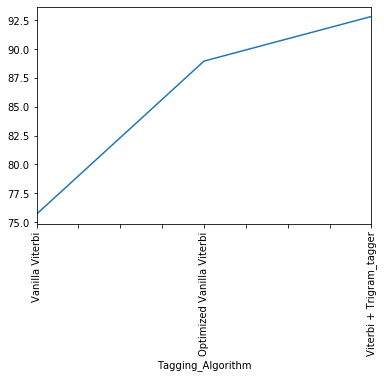

In [62]:
df_sample_test_data_acccuracy.plot.line(rot = 90, legend = False)

<b><h3><font color = 'green'>List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications </h3></b>

In [63]:
# test sentences

test_data_sentence_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
test_data_sentence_4 = 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
test_data_sentence_11 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'

<b><u><h3><font color = 'green'> Case: 1</h3></u></b>

In [64]:
# test_data_sentence_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'

words_test_data_sentence_2 = nltk.word_tokenize(test_data_sentence_2)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi = vanilla_viterbi(words_test_data_sentence_2)
print("Tagging sequence with vanilla_viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*125)

# pos tags with Viterbi_Backedup_By_Trigram_Tagger
pos_tagged_sequence_with_viterbi_trigram = Viterbi_Backedup_By_Trigram_Tagger(words_test_data_sentence_2)
print("Tagging sequence with Viterbi_Backedup_By_Trigram_Tagger:\n\n", pos_tagged_sequence_with_viterbi_trigram)

Tagging sequence with vanilla_viterbi -

 [('Android', 'ADV'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADV'), ('worldwide', 'ADV'), ('on', 'ADP'), ('smartphones', 'ADV'), ('since', 'ADP'), ('2011', 'ADV'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADV'), ('.', '.')]


-----------------------------------------------------------------------------------------------------------------------------
Tagging sequence with Viterbi_Backedup_By_Trigram_Tagger:

 [('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


In [65]:
cols = ['vanilla_viterbi_tags', 'viterbi_trigram_tags_with_corrections']
df_tags_correction_1 = pd.DataFrame(columns = cols)
df_tags_correction_1 = df_tags_correction_1.fillna(0)

df_tags_correction_1.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi]
df_tags_correction_1.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram]

df_tags_correction_1

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Android, ADV)","(Android, NOUN)"
1,"(has, VERB)","(has, VERB)"
2,"(been, VERB)","(been, VERB)"
3,"(the, DET)","(the, DET)"
4,"(best-selling, ADJ)","(best-selling, ADJ)"
5,"(OS, ADV)","(OS, NOUN)"
6,"(worldwide, ADV)","(worldwide, NOUN)"
7,"(on, ADP)","(on, ADP)"
8,"(smartphones, ADV)","(smartphones, VERB)"
9,"(since, ADP)","(since, ADP)"


####  Vanilla Viterbi algorithm : test sentence 2 incorrectly tagged words:

'Android' - PRT

#### Corrected by viterbi backed up by the Trigram Tagger

 'Android' - NOUN

<b><u><h3><font color = 'green'>Case: 2 </h3></u></b>

In [66]:
# test_data_sentence_4 = 'Twitter is an online news and social networking service on which users post
#                         and interact with messages known as tweets.'

words_test_data_sentence_4 = nltk.word_tokenize(test_data_sentence_4)

# pos tags with vanilla_viterbi
pos_tagged_sequence_with_vanilla_viterbi_4 = vanilla_viterbi(words_test_data_sentence_4)
print("Tagging sequence with vanilla_viterbi:\n\n", pos_tagged_sequence_with_vanilla_viterbi_4)

print('\n')
print('-'*125)

# pos tags with Viterbi_Backedup_By_Trigram_Tagger
pos_tagged_sequence_with_viterbi_trigram_4 = Viterbi_Backedup_By_Trigram_Tagger(words_test_data_sentence_4)
print("Tagging sequence with Viterbi_Backedup_By_Trigram_Tagger:\n\n", pos_tagged_sequence_with_viterbi_trigram_4)

Tagging sequence with vanilla_viterbi:

 [('Twitter', 'ADV'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADV'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'ADV'), ('with', 'ADP'), ('messages', 'ADV'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'ADV'), ('.', '.')]


-----------------------------------------------------------------------------------------------------------------------------
Tagging sequence with Viterbi_Backedup_By_Trigram_Tagger:

 [('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'NOUN'), ('with', 'ADP'), ('messages', 'VERB'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'NOUN'), ('.', '.')]


In [67]:
df_tags_correction_4 = pd.DataFrame(columns = cols)
df_tags_correction_4 = df_tags_correction_4.fillna(0)

df_tags_correction_4.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_4]
df_tags_correction_4.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_4]

df_tags_correction_4

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(Twitter, ADV)","(Twitter, NOUN)"
1,"(is, VERB)","(is, VERB)"
2,"(an, DET)","(an, DET)"
3,"(online, ADV)","(online, NOUN)"
4,"(news, NOUN)","(news, NOUN)"
5,"(and, CONJ)","(and, CONJ)"
6,"(social, ADJ)","(social, ADJ)"
7,"(networking, NOUN)","(networking, NOUN)"
8,"(service, NOUN)","(service, NOUN)"
9,"(on, ADP)","(on, ADP)"


####  Vanilla Viterbi algorithm : test sentence 4 incorrectly tagged words:

'Twitter' - PRT,  'online' - PRT,  'interact'-PRT,  'messages'-PRT,  'tweets' - PRT.

#### Corrected by viterbi backed up by the trigram tagger

 'Twitter' - NOUN,  'online' - NOUN,  'interact'-NOUN,  'messages'-VERB,  'tweets' - NOUN.

<b><u><h3><font color = 'green'>Case: 3</h3></u></b>

In [68]:
# test_data_sentence_11 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'

words_test_data_sentence_11 = nltk.word_tokenize(test_data_sentence_11)

# pos tags with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_11 = vanilla_viterbi(words_test_data_sentence_11)
print("Tagging sequence with Vanilla_Viterbi:\n\n", pos_tagged_sequence_with_vanilla_viterbi_11)

print('\n')
print('-'*125)

# pos tags with Viterbi_Backedup_By_Trigram_Tagger
pos_tagged_sequence_with_viterbi_trigram_11 = Viterbi_Backedup_By_Trigram_Tagger(words_test_data_sentence_11)
print("Tagging sequence with Viterbi_Backedup_By_Trigram_Tagger:\n\n", pos_tagged_sequence_with_viterbi_trigram_11)

Tagging sequence with Vanilla_Viterbi:

 [('NASA', 'ADV'), ('invited', 'ADV'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'ADV'), ('Satellite', 'ADV'), ('.', '.')]


-----------------------------------------------------------------------------------------------------------------------------
Tagging sequence with Viterbi_Backedup_By_Trigram_Tagger:

 [('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN'), ('.', '.')]


In [69]:
df_tags_correction_11 = pd.DataFrame(columns = cols)
df_tags_correction_11 = df_tags_correction_11.fillna(0)

df_tags_correction_11.vanilla_viterbi_tags = [tup for tup in pos_tagged_sequence_with_vanilla_viterbi_11]
df_tags_correction_11.viterbi_trigram_tags_with_corrections = [tup for tup in pos_tagged_sequence_with_viterbi_trigram_11]

df_tags_correction_11

,vanilla_viterbi_tags,viterbi_trigram_tags_with_corrections
0,"(NASA, ADV)","(NASA, NOUN)"
1,"(invited, ADV)","(invited, VERB)"
2,"(social, ADJ)","(social, ADJ)"
3,"(media, NOUN)","(media, NOUN)"
4,"(users, NOUN)","(users, NOUN)"
5,"(to, PRT)","(to, PRT)"
6,"(experience, NOUN)","(experience, NOUN)"
7,"(the, DET)","(the, DET)"
8,"(launch, NOUN)","(launch, NOUN)"
9,"(of, ADP)","(of, ADP)"


####  Vanilla Viterbi algorithm : test sentence 11 incorrectly tagged words:

 'NASA' - PRT,  'invited' - PRT,  'ICESAT-2'-PRT,  'Satellite'-PRT

#### Corrected by viterbi backed up by the trigram tagger

  'NASA' - NOUN,  'invited' - VERB,  'ICESAT-2'- NOUN,  'Satellite'-NOUN

<b><u><h3><font color = 'green'>Now lets see the tags and corrections for all the sample test sentences with both the methods.</h3></u></b>

- Method 1 - Considered only Transition probability for Unknown Words.
- Method 2 - Viterbi algorithm and backed it up with the Trigram Tagger which was inturn backed up by the rule based regex tagger.

In [70]:
# Default Vanilla Viterbi
# pos tags with Vanilla Viterbi
sample_test_data_tagged_sequence_with_vanilla_viterbi = vanilla_viterbi(test_tagged_words)
print("Tagging sequence with vanilla_viterbi:\n\n", sample_test_data_tagged_sequence_with_vanilla_viterbi)

print('\n')
print('-'*125)

# Method 1 - pos tags with unknown_words_with_vanilla_viterbi
sample_test_data_tagged_sequence_unknown_words = unknown_words_with_vanilla_viterbi(test_tagged_words)
print("Tagging sequence with Vanilla Viterbi using only transition probability for unknown words:\n\n", 
      sample_test_data_tagged_sequence_unknown_words)

print('\n')
print('-'*125)

# Method 2 - pos tags with Viterbi_Backedup_By_Trigram_Tagger
sample_test_data_tagged_sequence_with_viterbi_trigram = Viterbi_Backedup_By_Trigram_Tagger(test_tagged_words)
print("Tagging sequence with Viterbi_Backedup_By_Trigram_Tagger:\n\n", sample_test_data_tagged_sequence_with_viterbi_trigram)

Tagging sequence with vanilla_viterbi:

 [('Android', 'ADV'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADV'), ('.', '.'), ('Android', 'ADV'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADV'), ('worldwide', 'ADV'), ('on', 'ADP'), ('smartphones', 'ADV'), ('since', 'ADP'), ('2011', 'ADV'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADV'), ('.', '.'), ('Google', 'ADV'), ('and', 'CONJ'), ('Twitter', 'ADV'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADV'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADV'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADV'), ("'s", 'PRT'), ('firehose', 'ADV'), ('.', '.'), ('Twitter', 'ADV'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADV'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on',

In [71]:
# A dataframe showing - 
# 1. the actual tags using nltk.pos_tag_sent
# 2. words as tagged by vanilla viterbi
# 3. words as tagged by Vanilla_Viterbi_With_Unknown_Words - METHOD - 1
# 4. words as tagged by Viterbi_Backedup_By_Trigram_Tagger - METHOD - 2

cols1 = ['actual_tags', 'as_tagged_by_vanilla_viterbi', 'as_tagged_by_Vanilla_Viterbi_for_Unknown_Words',
            'as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger']

df_tags_comparison = pd.DataFrame(columns = cols1)
df_tags_comparison = df_tags_comparison.fillna(0)

# Actual tags
df_tags_comparison.actual_tags = [tup for tup in tagged_words_test_run_base]

# tags by vanilla viterbi
df_tags_comparison.as_tagged_by_vanilla_viterbi = [tup for tup in sample_test_data_tagged_sequence_with_vanilla_viterbi]

# tags by Vanilla_Viterbi_With_Unknown_Words - METHOD - 1
df_tags_comparison.as_tagged_by_Vanilla_Viterbi_for_Unknown_Words = [tup for tup in sample_test_data_tagged_sequence_unknown_words]

# tags by Viterbi_Backedup_By_Trigram_Tagger - METHOD - 2
df_tags_comparison.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger = [tup for tup in 
                                                                            sample_test_data_tagged_sequence_with_viterbi_trigram]

df_tags_comparison[df_tags_comparison.as_tagged_by_vanilla_viterbi != 
                   df_tags_comparison.as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger]

,actual_tags,as_tagged_by_vanilla_viterbi,as_tagged_by_Vanilla_Viterbi_for_Unknown_Words,as_tagged_by_Vanilla_Viterbi_backed_by_trigram_tagger
0,"(Android, NOUN)","(Android, ADV)","(Android, NOUN)","(Android, NOUN)"
8,"(Google, NOUN)","(Google, ADV)","(Google, NOUN)","(Google, NOUN)"
10,"(Android, NOUN)","(Android, ADV)","(Android, NOUN)","(Android, NOUN)"
15,"(OS, NOUN)","(OS, ADV)","(OS, NOUN)","(OS, NOUN)"
16,"(worldwide, NOUN)","(worldwide, ADV)","(worldwide, NOUN)","(worldwide, NOUN)"
18,"(smartphones, NOUN)","(smartphones, ADV)","(smartphones, NOUN)","(smartphones, VERB)"
20,"(2011, NUM)","(2011, ADV)","(2011, NOUN)","(2011, NUM)"
25,"(2013, NUM)","(2013, ADV)","(2013, NOUN)","(2013, NUM)"
27,"(Google, NOUN)","(Google, ADV)","(Google, NOUN)","(Google, NOUN)"
29,"(Twitter, NOUN)","(Twitter, ADV)","(Twitter, NOUN)","(Twitter, NOUN)"


<b><u><h3><font color = 'green'> Conclusion : </h3></u></b>
##### Most of the words that were incorrectly tagged by the Vanilla Viterbi algorithm were corrected by the Viterbi algorithm backed up by the Trigram Tagger.
##### Below are the 2 modification techniques used for the original Vanilla Viterbi

##### Technique 1 
- Considered only Transition probability for Unknown Words.
- Achieved 93% accuracy.

##### Technique 2 
- Viterbi algorithm and backed it up with the trigram tagger which was inturn backed up by the rule based 
regex tagger.
- Achieved 95% accuracy.
- Ans also it's achieved an accuracy of 92% on sample test data